### Determining which Ensembles Nums Accurately Predict the CAO

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from metpy.units import units
from metpy import calc as mpcalc
import math
import netCDF4
from netCDF4 import Dataset
from datetime import datetime, date, timedelta
from itertools import chain

Importing in era-i, era-5, and S2S model data that's been averaged over a lat-lon. All data is at 00Z and 1000hPa

In [2]:
#Reading in rd_t Datasets made in ensemble_mean script (odd=hightop, even=lowtop)
ct_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/ct_llmn_t.nc")
stdvt_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/stdvt_llmn_t.nc")
rt1_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/realt_jan.nc")
rt2_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/realt_feb.nc")
t_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/ECMWF_llmn_t.nc")
t2_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/ECCC_llmn_t.nc")
t3_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/UKMO_llmn_t.nc")
t4_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/CMA_llmn_t.nc")
t5_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/JMA_llmn_t.nc")
t6_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/CNR_llmn_t.nc")

In [3]:
#Joining together the era-5 data in order to have January and February data together in one dataset
rt_llmn_ds = xr.concat([rt1_llmn_ds,rt2_llmn_ds], dim='time')

In [4]:
#Creating variables for the step and date of forecast
step = t_llmn_ds.step["step.days"] #<-- days forecasted out (47)
fd = t_llmn_ds.date["date.dayofyear"] #<--day of forecast(8)
step2 = t2_llmn_ds.step["step.days"] #<-- days forecasted out (32)
fd2 = t2_llmn_ds.date["date.dayofyear"] #<--day of forecast(4)
step3 = t3_llmn_ds.step["step.days"] 
fd3 = t3_llmn_ds.date["date.dayofyear"]
step4 = t4_llmn_ds.step["step.days"] 
fd4 = t4_llmn_ds.date["date.dayofyear"]
step5 = t5_llmn_ds.step["step.days"] 
fd5 = t5_llmn_ds.date["date.dayofyear"]
step6 = t6_llmn_ds.step["step.days"]
fd6 = t6_llmn_ds.date["date.dayofyear"]

#Creating time and number variables
time = ct_llmn_ds['time']
rt_time = rt_llmn_ds.time['time.dayofyear']
n1 = t_llmn_ds['number'].to_numpy()
n2 = t2_llmn_ds['number'].to_numpy()
n3 = t3_llmn_ds['number'].to_numpy()
n4 = t4_llmn_ds['number'].to_numpy()
n5 = t5_llmn_ds['number'].to_numpy()
n6 = t6_llmn_ds['number'].to_numpy()

In [5]:
#Creating data array of forecast day and step
doy1 = fd + step
doy2 = fd2 + step2
doy3 = fd3 + step3
doy4 = fd4 + step4
doy5 = fd5 + step5
doy6 = fd6 + step6

Following cell is making the climo (era-i) data's coordinates match the model data

In [6]:
#Assigning number to climo lat/lon means
ct1_match = ct_llmn_ds.assign_coords(number=('number', n1))
ct2_match = ct_llmn_ds.assign_coords(number=('number', n2))
ct3_match = ct_llmn_ds.assign_coords(number=('number', n3))
ct4_match = ct_llmn_ds.assign_coords(number=('number', n4))
ct5_match = ct_llmn_ds.assign_coords(number=('number', n5))
ct6_match = ct_llmn_ds.assign_coords(number=('number', n6))

#Giving climo data forecast days and steps
ct1_match = ct1_match.sel(time=doy1)
ct2_match = ct2_match.sel(time=doy2)
ct3_match = ct3_match.sel(time=doy3)
ct4_match = ct4_match.sel(time=doy4)
ct5_match = ct5_match.sel(time=doy5)
ct6_match = ct6_match.sel(time=doy6)
ct_rt_match = ct_llmn_ds.sel(time=rt_time)
stdvt_match = stdvt_llmn_ds.sel(time=rt_time)

Calculating the temperature anomalies for the model data and the era-5 data

In [7]:
#Calculating Mean Area Temp Anoms
anom_t = t_llmn_ds - ct1_match
anom_t2 = t2_llmn_ds - ct2_match
anom_t3 = t3_llmn_ds - ct3_match
anom_t4 = t4_llmn_ds - ct4_match
anom_t5 = t5_llmn_ds - ct5_match
anom_t6 = t6_llmn_ds - ct6_match
anom_rt = rt_llmn_ds.t.values - ct_rt_match.t.values

In [8]:
#Era-5 data is weird so, I'm making the actual anomalies back into xarray
anom_rt_ds = xr.DataArray(data=anom_rt, dims=["time"], coords=dict(time=rt_time),
                        attrs=dict(description="Temperature Anomaly", units="Kelvin"),)

Below are a couple of plots where I'm just playing with the data.

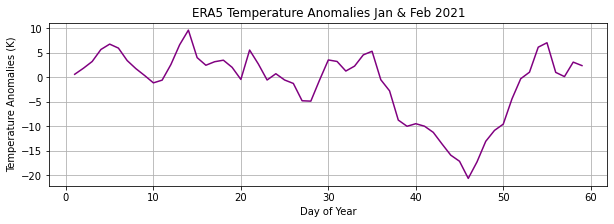

In [9]:
#Plotting the actual temperature anomalies
anom_rt_ds.plot(color='purple')
plt.grid(True)
plt.title('ERA5 Temperature Anomalies Jan & Feb 2021')
plt.xlabel('Day of Year')
plt.ylabel('Temperature Anomalies (K)')
fig = mlp.pyplot.gcf()
fig.set_size_inches(10, 3)

### Onset/length of the CAO which was determined to be Feb 7th-19th

In [10]:
time_of_CAO = anom_rt_ds < -.75* stdvt_match
time_of_CAO

<xarray.Dataset>
Dimensions:  (time: 59)
Coordinates:
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 55.0 56.0 57.0 58.0 59.0
    hour     float64 ...
    lev      int32 ...
    level    int32 1000
Data variables:
    t        (time) bool False False False False ... False False False False

Creating date variable in order to select the day I want (February 7th)

In [11]:
dateyouwant = datetime(2021, 2, 7, 0, 0, 0)
dateyouwant.strftime("%Y-%m-%d %H:%M:%S:%f")

'2021-02-07 00:00:00:000000'

In [12]:
dayiwant=anom_t['date'][0] + anom_t['step'][34]
dayiwant

<xarray.DataArray ()>
array('2021-02-07T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 1000
    date     datetime64[ns] 2021-01-04
    hour     float64 0.0
    lev      int32 1000
    step     timedelta64[ns] 34 days

In [13]:
#This is looping over each of the models in order to determine the date and step needed in 
# order to get the wanted date (FEB 7th)
stp1 = []
for ii in anom_t['date']:
    for jj in anom_t['step']:
        if ii + jj == dayiwant:
            ii1 = ii.date.values
            jj1 = jj.step.dt.days.values.tolist()
            stp1.append(jj1)
            print(f'ECMWF:{ii1}, {jj1}')
stp2 = []
for ii in anom_t2['date']:
    for jj in anom_t2['step']:
        if ii + jj == dayiwant:
            ii2 = ii.date.values
            jj2 = jj.step.dt.days.values.tolist()
            stp2.append(jj2)
#            print(f'ECCC:{ii2}, {jj2}')
stp3 = []            
for ii in anom_t3['date']:
    for jj in anom_t3['step']:
        if ii + jj == dayiwant:
            ii3 = ii.date.values
            jj3 = jj.step.dt.days.values.tolist()
            stp3.append(jj3)
#            print(f'UKMO:{ii3}, {jj3}')
stp4 = []                        
for ii in anom_t4['date']:
    for jj in anom_t4['step']:
        if ii + jj == dayiwant:
            ii4 = ii.date.values
            jj4 = jj.step.dt.days.values.tolist()
            stp2.append(jj4)
#            print(f'CMA:{ii4}, {jj4}')
stp5 = []                        
for ii in anom_t5['date']:
    for jj in anom_t5['step']:
        if ii + jj == dayiwant:
            ii5 = ii.date.values
            jj5 = jj.step.dt.days.values.tolist()
            stp5.append(jj5)
#            print(f'JMA:{ii5}, {jj5}')
stp6 = []            
for ii in anom_t6['date']:
    for jj in anom_t6['step']:
        if ii + jj == dayiwant:
            ii6 = ii.date.values
            jj6 = jj.step.dt.days.values.tolist()
            stp6.append(jj6)
#            print(f'CNR:{ii6}, {jj6}')

ECMWF:2021-01-04T00:00:00.000000000, 34
ECMWF:2021-01-07T00:00:00.000000000, 31
ECMWF:2021-01-11T00:00:00.000000000, 27
ECMWF:2021-01-14T00:00:00.000000000, 24
ECMWF:2021-01-18T00:00:00.000000000, 20
ECMWF:2021-01-21T00:00:00.000000000, 17
ECMWF:2021-01-25T00:00:00.000000000, 13
ECMWF:2021-01-28T00:00:00.000000000, 10


This is a slice for the lenght of the CAO

In [14]:
cao_length = slice("2021-02-07T00:00:00.000000000", "2021-02-19T00:00:00.000000000")
cao_len_date = rt_llmn_ds.time.isel(time = slice(37,50))

Determining the ERA-I Standard Deviation of Temp for length of CAO

In [15]:
stdv_cao_len = stdvt_match.t.isel(time = slice(37,50))
cao_len = stdvt_match.time.isel(time = slice(37,50))

The next 6 cells are determining the number of hits for each initialization date of each model.

In [16]:
#Making a definition in order to determine the ensemble number that successfully predicted the CAO
## https://stackoverflow.com/questions/5419204/index-of-duplicates-items-in-a-python-list
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [17]:
###This is not RIGHT!!! Need which ensembles were correct for each initialization with 13 steps for CAO length
ecmwf_hit_list=[]
ecmwf_ensnum=[]
for m in range(0,8,1):
    hits_by_row=[]
    for n in range(0,13,1):
        at_sel1 = anom_t.sel(date = anom_t.date == anom_t.date[m], step=anom_t.step.dt.days == stp1[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        hits_by_row.append(ct_tot_list)
        
        for k in range(0,50,1): #<--This loop determines which ensemble runs successfully predicted the CAO
            succ_ens_list = cao_t1.t.values.tolist()
            succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list)))) 
            succ_ensnum = list_duplicates_of(succ_ens_list, True)
    ecmwf_ensnum.append(succ_ensnum)
    ecmwf_hit_list.append(hits_by_row)
print(f'Successful Ensemble Runs:{ecmwf_ensnum}') 
print(f'Number of hits:{ecmwf_hit_list}')

Successful Ensemble Runs:[[1, 10, 13, 16, 18, 20, 21, 25, 33, 34, 35, 40, 42, 46], [2, 3, 12, 15, 18, 20, 22, 25, 38, 42, 45, 47], [0, 2, 9, 18, 26, 28, 29, 34, 37, 38], [1, 7, 15, 17, 18, 20, 21, 26, 29, 31, 39, 41, 42, 45, 46, 49], [18, 19, 20, 22, 23, 31, 43, 47], [8, 11, 14, 17, 20, 22, 25, 30, 34, 35, 42, 43, 45, 46, 47], [2, 4, 10, 20, 32, 33, 35, 41, 42, 44, 45, 46, 47], [12, 13, 14, 16, 18, 24, 29, 35, 37, 38, 41, 45, 47]]
Number of hits:[[9.0, 9.0, 6.0, 7.0, 7.0, 8.0, 6.0, 11.0, 13.0, 10.0, 12.0, 11.0, 14.0], [14.0, 8.0, 11.0, 10.0, 10.0, 10.0, 9.0, 11.0, 6.0, 3.0, 5.0, 7.0, 12.0], [4.0, 8.0, 5.0, 6.0, 6.0, 8.0, 5.0, 7.0, 8.0, 6.0, 12.0, 8.0, 10.0], [7.0, 8.0, 7.0, 12.0, 7.0, 6.0, 4.0, 7.0, 12.0, 6.0, 8.0, 11.0, 16.0], [10.0, 9.0, 8.0, 12.0, 12.0, 11.0, 8.0, 11.0, 8.0, 11.0, 11.0, 6.0, 8.0], [4.0, 8.0, 7.0, 6.0, 12.0, 10.0, 6.0, 8.0, 8.0, 8.0, 9.0, 12.0, 15.0], [10.0, 8.0, 8.0, 7.0, 6.0, 9.0, 10.0, 11.0, 13.0, 12.0, 17.0, 13.0, 13.0], [28.0, 26.0, 11.0, 12.0, 9.0, 9.0, 14.0, 2

In [18]:
ecmwf_ensnum=[]
for m in range(0,8,1):
    hits_by_date=[]
    for n in range(0,13,1):
        hits_by_step = []
        at_sel1 = anom_t.sel(date = anom_t.date == anom_t.date[m], step=anom_t.step.dt.days == stp1[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        for k in range(0,50,1): #<--This loop determines which ensemble runs successfully predicted the CAO
            succ_ens_list = cao_t1.t.values.tolist()
            succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list)))) 
            succ_ensnum = list_duplicates_of(succ_ens_list, True)
    ecmwf_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{ecmwf_ensnum}') 


Successful Ensemble Runs:[[1, 10, 13, 16, 18, 20, 21, 25, 33, 34, 35, 40, 42, 46], [2, 3, 12, 15, 18, 20, 22, 25, 38, 42, 45, 47], [0, 2, 9, 18, 26, 28, 29, 34, 37, 38], [1, 7, 15, 17, 18, 20, 21, 26, 29, 31, 39, 41, 42, 45, 46, 49], [18, 19, 20, 22, 23, 31, 43, 47], [8, 11, 14, 17, 20, 22, 25, 30, 34, 35, 42, 43, 45, 46, 47], [2, 4, 10, 20, 32, 33, 35, 41, 42, 44, 45, 46, 47], [12, 13, 14, 16, 18, 24, 29, 35, 37, 38, 41, 45, 47]]


In [19]:
#hope = np.array(ecmwf_ensnum)
test = xr.DataArray(data=ecmwf_ensnum, dims=["date"], coords=dict(time=anom_t.date),
                        attrs=dict(description="Ensemble hits"))
test

/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/xarray/core/variable.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)


<xarray.DataArray (date: 8)>
array([list([1, 10, 13, 16, 18, 20, 21, 25, 33, 34, 35, 40, 42, 46]),
       list([2, 3, 12, 15, 18, 20, 22, 25, 38, 42, 45, 47]),
       list([0, 2, 9, 18, 26, 28, 29, 34, 37, 38]),
       list([1, 7, 15, 17, 18, 20, 21, 26, 29, 31, 39, 41, 42, 45, 46, 49]),
       list([18, 19, 20, 22, 23, 31, 43, 47]),
       list([8, 11, 14, 17, 20, 22, 25, 30, 34, 35, 42, 43, 45, 46, 47]),
       list([2, 4, 10, 20, 32, 33, 35, 41, 42, 44, 45, 46, 47]),
       list([12, 13, 14, 16, 18, 24, 29, 35, 37, 38, 41, 45, 47])],
      dtype=object)
Coordinates:
    time     (date) datetime64[ns] 2021-01-04 2021-01-07 ... 2021-01-28
Dimensions without coordinates: date
Attributes:
    description:  Ensemble hits

In [20]:
stdv_test = stdv_cao_len.assign_coords(time = cao_len_date)
stdv_test

<xarray.DataArray 't' (time: 13)>
array([6.165233, 6.159482, 6.153749, 6.148018, 6.142265, 6.136469, 6.130604,
       6.124644, 6.118561, 6.112327, 6.105913, 6.099288, 6.092422])
Coordinates:
  * time     (time) datetime64[ns] 2021-02-07 2021-02-08 ... 2021-02-19
    hour     float64 ...
    lev      int32 ...
    level    int32 1000

In [21]:
test2 = anom_t.t.loc[:,:,:] <= -0.75 * stdv_test
test2

<xarray.DataArray 't' (date: 8, step: 47, number: 50, time: 13)>
array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
...
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]])
Coordinates:
    level    int32 1000
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
  * step     (step) timedelta64[ns] 0 days 1 days 2 days ... 45 days 46 days
  * date     (date) datetime64[ns] 2021-01-04 2021-01-07 ... 2021-01-28
  * time     (time) datetime64[ns] 2021-02-07 2021-02-08 ... 2021-02-19
    hour     float64 0.0
    lev      int32 1000

In [22]:
at_sel1 = anom_t.sel(date = anom_t.date == anom_t.date[0], step=anom_t.step.dt.days == stp1[0]+0)
cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[0]
ct = cao_t1.where(cao_t1.t == True)
ct

<xarray.Dataset>
Dimensions:  (date: 1, step: 1, number: 50)
Coordinates:
    level    int32 1000
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
  * step     (step) timedelta64[ns] 34 days
  * date     (date) datetime64[ns] 2021-01-04
    time     (date, step) float64 38.0
    hour     float64 0.0
    lev      int32 1000
Data variables:
    t        (date, step, number) float64 nan nan nan nan ... nan nan nan nan

### Need to figure out how to keep this as an Xarray dataset or dataarray so that the data will be easier to use/plot

In [ ]:
#could be helpful np.arange(0,len(anom_t['date'])

In [23]:
ecmwf_ensnum_list = []
for m in range(0,8,1):
    for n in range(0,13,1):
        at_sel1 = anom_t.sel(date = anom_t.date == anom_t.date[m], step=anom_t.step.dt.days == stp1[m]+n)
        cao_t1 = at_sel1.t.loc[:] <= -0.75 * stdv_test[n]
        ct = cao_t1.where(cao_t1 == True)
        ecmwf_ensnum_list.append(ct)
ecmwf_ensnum_da = xr.concat(ecmwf_ensnum_list, dim='hits')

ecmwf_ensnum_da = ecmwf_ensnum_da.reset_coords(names=['level','hour','lev'],drop='True')
ecmwf_ensnum_da

<xarray.DataArray 't' (hits: 104, date: 8, step: 37, number: 50)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * step     (step) timedelta64[ns] 10 days 11 days 12 days ... 45 days 46 days
  * date     (date) datetime64[ns] 2021-01-04 2021-01-07 ... 2021-01-28
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: hits

In [24]:
ecmwf_ensnum_da.isel(date=0)

<xarray.DataArray 't' (hits: 104, step: 37, number: 50)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * step     (step) timedelta64[ns] 10 days 11 days 12 days ... 45 days 46 days
    date     datetime64[ns] 2021-01-04
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: hits

In [25]:
ecmwf_jan4 = ecmwf_ensnum_da.isel(date=0).sel(step=slice('34 days', '47 days'))
ecmwf_jan7 = ecmwf_ensnum_da.isel(date=1).sel(step=slice('31 days', '44 days'))
ecmwf_jan11 = ecmwf_ensnum_da.isel(date=2).sel(step=slice('27 days', '40 days'))
ecmwf_jan14 = ecmwf_ensnum_da.isel(date=3).sel(step=slice('24 days', '37 days'))
ecmwf_jan18 = ecmwf_ensnum_da.isel(date=4).sel(step=slice('20 days', '33 days'))
ecmwf_jan21 = ecmwf_ensnum_da.isel(date=5).sel(step=slice('17 days', '30 days'))
ecmwf_jan25 = ecmwf_ensnum_da.isel(date=6).sel(step=slice('13 days', '26 days'))
ecmwf_jan28 = ecmwf_ensnum_da.isel(date=7).sel(step=slice('10 days', '23 days'))

In [28]:
ecmwf_jan4

<xarray.DataArray 't' (hits: 104, step: 13, number: 50)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * step     (step) timedelta64[ns] 34 days 35 days 36 days ... 45 days 46 days
    date     datetime64[ns] 2021-01-04
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: hits

In [29]:
stp1s = ['34 days','31 days','27 days','24 days','20 days','17 days','13 days','10 days']
stp1e = ['47 days','44 days','40 days','37 days','33 days','30 days','26 days','23 days']

In [30]:
slice(stp1[0],stp1[0]+13)

slice(34, 47, None)

In [31]:
slice('10 days', '23 days')

slice('10 days', '23 days', None)

In [32]:
###This is the number of hits for each ensemble number initialized on Jan 4th for the full length of the CAO
test = []
for m in range(0,8,1):
    maybe = ecmwf_ensnum_da.isel(date=ecmwf_ensnum_da[m], step=ecmwf_ensnum_da.step.dt.days == slice(stp1[0], stp1[m]+13))
    for k in range(1,51,1):
        filler = maybe.sel(number = [k]).sum()
        test.append(filler)
test = xr.concat(test, dim='hits')
test

TypeError: invalid indexer array, does not have integer dtype: array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [33]:
ecmwf_ensnum_list = []
test = []

for m in range(0,8,1):
    for n in range(0,13,1):
        at_sel1 = anom_t.sel(date = anom_t.date == anom_t.date[m], step=anom_t.step.dt.days == stp1[m]+n)
        cao_t1 = at_sel1.t.loc[:] <= -0.75 * stdv_test[n]
        ct = cao_t1.where(cao_t1 == True)
        ecmwf_ensnum_list.append(ct)
ecmwf_ensnum_da = xr.concat(ecmwf_ensnum_list, dim='hits')

for i in range(0,8,1):
    test2 = []
    hope = ecmwf_ensnum_da.isel(date=0).sel(step=slice(stp1s[0], stp1e[0]))
    for k in range(0,50,1):
        filler =hope.isel(number = [k]).sum()
        test2.append(filler)
#    test.append(test2)     
#test = xr.concat(test, dim='hits')
test2
#filler
#ecmwf_ensnum_da = ecmwf_ensnum_da.reset_coords(names=['level','hour','lev'],drop='True') 

[<xarray.DataArray 't' ()>
 array(2.)
 Coordinates:
     date     datetime64[ns] 2021-01-04
     level    int32 1000
     hour     float64 0.0
     lev      int32 1000,
 <xarray.DataArray 't' ()>
 array(9.)
 Coordinates:
     date     datetime64[ns] 2021-01-04
     level    int32 1000
     hour     float64 0.0
     lev      int32 1000,
 <xarray.DataArray 't' ()>
 array(0.)
 Coordinates:
     date     datetime64[ns] 2021-01-04
     level    int32 1000
     hour     float64 0.0
     lev      int32 1000,
 <xarray.DataArray 't' ()>
 array(0.)
 Coordinates:
     date     datetime64[ns] 2021-01-04
     level    int32 1000
     hour     float64 0.0
     lev      int32 1000,
 <xarray.DataArray 't' ()>
 array(0.)
 Coordinates:
     date     datetime64[ns] 2021-01-04
     level    int32 1000
     hour     float64 0.0
     lev      int32 1000,
 <xarray.DataArray 't' ()>
 array(1.)
 Coordinates:
     date     datetime64[ns] 2021-01-04
     level    int32 1000
     hour     float64 0.0
     lev    

In [ ]:
for m in range(0,8,1):
    ecmwf_ensnum_da.isel(date = ecmwf_ensnum_da.date == ecmwf_ensnum_da.date[m]).plot()

In [ ]:
eccc_hit_list=[]
for m in range(0,4,1):
    hits_by_rows=[]
    for n in range(0,13,1):
        at_sel1 = anom_t2.sel(date = anom_t2.date == anom_t2.date[m], step=anom_t2.step.dt.days == stp2[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        hits_by_rows.append(ct_tot_list)
    eccc_hit_list.append(hits_by_rows)
print(eccc_hit_list)

In [ ]:
ukmo_hit_list = []
for m in range(0,31,1):
    hits_by_rows=[]
    for n in range(0,13,1):
        at_sel1 = anom_t3.sel(date = anom_t3.date == anom_t3.date[m], step=anom_t3.step.dt.days == stp3[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        hits_by_rows.append(ct_tot_list)
    ukmo_hit_list.append(hits_by_rows)
print(ukmo_hit_list)

In [ ]:
cma_hit_list=[]
for m in range(0,8,1):
    hits_by_row=[]
    for n in range(0,13,1):
        at_sel1 = anom_t4.sel(date = anom_t4.date == anom_t4.date[m], step=anom_t4.step.dt.days == stp4[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        hits_by_row.append(ct_tot_list)
    cma_hit_list.append(hits_by_row)
print(cma_hit_list)

In [ ]:
jma_hit_list=[]
for m in range(0,4,1):
    hits_by_row=[]
    for n in range(0,13,1):
        at_sel1 = anom_t5.sel(date = anom_t5.date == anom_t5.date[m], step=anom_t5.step.dt.days == stp5[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        hits_by_row.append(ct_tot_list)
    jma_hit_list.append(hits_by_row)
print(jma_hit_list)

In [ ]:
cnr_hit_list=[]
for m in range(0,4,1):
    hits_by_row=[]
    for n in range(0,13,1):
        at_sel1 = anom_t6.sel(date = anom_t6.date == anom_t6.date[m], step=anom_t6.step.dt.days == stp6[m]+n)
        cao_t1 = at_sel1 <= -0.75 * stdv_cao_len[n]
        ct = cao_t1.where(cao_t1.t == True)
        ct_tot = ct.sum().t.values 
        ct_tot_list = ct_tot.tolist()
        hits_by_row.append(ct_tot_list)
    cnr_hit_list.append(hits_by_row)
print(cnr_hit_list)

In [ ]:
#Creating a definition to calculate the sum of my nested lists
def nested_sum(my_list):
    total = 0  # don't use `sum` as a variable name
    for i in my_list:
        if isinstance(i, list):  # checks if `i` is a list
            total += nested_sum(i)
        else:
            total += i
    return total

In [ ]:
#Calculating the sums of the hit lists
ecmwf_hits = nested_sum(ecmwf_hit_list)
eccc_hits = nested_sum(eccc_hit_list)
ukmo_hits = nested_sum(ukmo_hit_list)
cma_hits = nested_sum(cma_hit_list)
jma_hits = nested_sum(jma_hit_list)
cnr_hits = nested_sum(cnr_hit_list)

In [ ]:
#Calculating the total % of hits for the length of the CAO
ecmwf_totper = 100 * ecmwf_hits/(50*13*8) #<-denominator = ensembles * CAO length * # of initialization dates
eccc_totper = 100 * eccc_hits/(20*13*4)
ukmo_totper = 100 * ukmo_hits/(3*13*31)
cma_totper = 100 * cma_hits/(3*13*8)
jma_totper = 100 * jma_hits/(49*13*4)
cnr_totper = 100 * cnr_hits/(40*13*4)

In [ ]:
#calculating total HT and LT %
ht_totper = (ecmwf_totper + ukmo_totper + jma_totper)/3
lt_totper = (eccc_totper + cma_totper + cnr_totper)/3

Now we need to determine the number of hits based off of the initialization of the model runs. This will allow us to see how the model's accuracy changed over time.

In [ ]:
#Creating Slices in order to select dates that are weekly
##Note: There's no wk1 because there are no forecasts initialized in Feb.
wk2 = slice("2021-01-25T00:00:00.000000000", "2021-01-31T00:00:00.000000000") #<--  7-13 days in advance
wk3 = slice("2021-01-18T00:00:00.000000000", "2021-01-24T00:00:00.000000000") #<-- 14-20 days in advance
wk4 = slice("2021-01-11T00:00:00.000000000", "2021-01-17T00:00:00.000000000") #<-- 21-27 days in advance 
wk5 = slice("2021-01-04T00:00:00.000000000", "2021-01-10T00:00:00.000000000") #<-- 28-34 days in advance
#making the weeks into a list
weeks = [wk2, wk3, wk4, wk5]

Below I'll be determining how many initialization dates fall into each date range for each model

In [ ]:
ecmwf_wk2 = anom_t.sel(date = wk2).date #<-- 1/25, 1/28
ecmwf_wk3 = anom_t.sel(date = wk3).date #<-- 1/18, 1/21
ecmwf_wk4 = anom_t.sel(date = wk4).date #<-- 1/11, 1/14
ecmwf_wk5 = anom_t.sel(date = wk5).date #<-- 1/4, 1/7

In [ ]:
eccc_wk2 = anom_t2.sel(date = wk2).date #<-- 1/28
eccc_wk3 = anom_t2.sel(date = wk3).date #<-- 1/21
eccc_wk4 = anom_t2.sel(date = wk4).date #<-- 1/14
eccc_wk5 = anom_t2.sel(date = wk5).date #<-- 1/7

In [ ]:
ukmo_wk2 = anom_t3.sel(date = wk2).date #<-- 1/25, 1/26, 1/27, 1/28, 1/29, 1/30, 1/31
ukmo_wk3 = anom_t3.sel(date = wk3).date #<-- 1/18, 1/19, 1/20, 1/21, 1/22, 1/23, 1/24
ukmo_wk4 = anom_t3.sel(date = wk4).date #<-- 1/11, 1/12, 1/13, 1/14, 1/15, 1/16, 1/17
ukmo_wk5 = anom_t3.sel(date = wk5).date #<-- 1/4, 1/5, 1/6, 1/7, 1/8, 1/9, 1/10

In [ ]:
cma_wk2 = anom_t4.sel(date = wk2).date #<-- 1/25, 1/28
cma_wk3 = anom_t4.sel(date = wk3).date #<-- 1/18, 1/21
cma_wk4 = anom_t4.sel(date = wk4).date #<-- 1/11, 1/14
cma_wk5 = anom_t4.sel(date = wk5).date #<-- 1/4, 1/7

In [ ]:
jma_wk2 = anom_t5.sel(date = wk2).date #<-- 1/27
jma_wk3 = anom_t5.sel(date = wk3).date #<-- 1/20
jma_wk4 = anom_t5.sel(date = wk4).date #<-- 1/13
jma_wk5 = anom_t5.sel(date = wk5).date #<-- 1/6

In [ ]:
cnr_wk2 = anom_t6.sel(date = wk2).date #<-- 1/28
cnr_wk3 = anom_t6.sel(date = wk3).date #<-- 1/21
cnr_wk4 = anom_t6.sel(date = wk4).date #<-- 1/14
cnr_wk5 = anom_t6.sel(date = wk5).date #<-- 1/7

Below I will be noting the number of hits per these date ranges which will be done manually.

In [ ]:
ecmwf_wk5_tothits = np.sum(ecmwf_hit_list[0:2])
ecmwf_wk4_tothits = np.sum(ecmwf_hit_list[2:4])
ecmwf_wk3_tothits = np.sum(ecmwf_hit_list[4:6])
ecmwf_wk2_tothits = np.sum(ecmwf_hit_list[6:8])

In [ ]:
eccc_wk5_tothits = np.sum(eccc_hit_list[0:1])
eccc_wk4_tothits = np.sum(eccc_hit_list[1:2])
eccc_wk3_tothits = np.sum(eccc_hit_list[2:3])
eccc_wk2_tothits = np.sum(eccc_hit_list[3:4])

In [ ]:
ukmo_wk5_tothits = np.sum(ukmo_hit_list[0:7])
ukmo_wk4_tothits = np.sum(ukmo_hit_list[7:14])
ukmo_wk3_tothits = np.sum(ukmo_hit_list[14:21])
ukmo_wk2_tothits = np.sum(ukmo_hit_list[21:28])

In [ ]:
cma_wk5_tothits = np.sum(cma_hit_list[0:2])
cma_wk4_tothits = np.sum(cma_hit_list[2:4])
cma_wk3_tothits = np.sum(cma_hit_list[4:6])
cma_wk2_tothits = np.sum(cma_hit_list[6:8])

In [ ]:
jma_wk5_tothits = np.sum(jma_hit_list[0:1])
jma_wk4_tothits = np.sum(jma_hit_list[1:2])
jma_wk3_tothits = np.sum(jma_hit_list[2:3])
jma_wk2_tothits = np.sum(jma_hit_list[3:4])

In [ ]:
cnr_wk5_tothits = np.sum(cnr_hit_list[0:1])
cnr_wk4_tothits = np.sum(cnr_hit_list[1:2])
cnr_wk3_tothits = np.sum(cnr_hit_list[2:3])
cnr_wk2_tothits = np.sum(cnr_hit_list[3:4])

In [ ]:
#Determining the percent for each week for ECMWF
ecmwf_wk5per = 100 * ecmwf_wk5_tothits / (50*13*2) #<- denominator = ensembles * steps * dates
ecmwf_wk4per = 100 * ecmwf_wk4_tothits / (50*13*2)
ecmwf_wk3per = 100 * ecmwf_wk3_tothits / (50*13*2)
ecmwf_wk2per = 100 * ecmwf_wk2_tothits / (50*13*2)

In [ ]:
#Determining the percent for each week for ECCC
eccc_wk5per = 100 * eccc_wk5_tothits / (20*13*1) #<- denominator = ensembles * steps * dates
eccc_wk4per = 100 * eccc_wk4_tothits / (20*13*1)
eccc_wk3per = 100 * eccc_wk3_tothits / (20*13*1)
eccc_wk2per = 100 * eccc_wk2_tothits / (20*13*1)

In [ ]:
#Determining the percent for each week for UKMO
ukmo_wk5per = 100 * ukmo_wk5_tothits / (3*13*7) #<- denominator = ensembles * steps * dates
ukmo_wk4per = 100 * ukmo_wk4_tothits / (3*13*7)
ukmo_wk3per = 100 * ukmo_wk3_tothits / (3*13*7)
ukmo_wk2per = 100 * ukmo_wk2_tothits / (3*13*7)

In [ ]:
#Determining the percent for each week for CMA
cma_wk5per = 100 * cma_wk5_tothits / (3*13*2) #<- denominator = ensembles * steps * dates
cma_wk4per = 100 * cma_wk4_tothits / (3*13*2)
cma_wk3per = 100 * cma_wk3_tothits / (3*13*2)
cma_wk2per = 100 * cma_wk2_tothits / (3*13*2)

In [ ]:
#Determining the percent for each week for JMA
jma_wk5per = 100 * jma_wk5_tothits / (49*13*1) #<- denominator = ensembles * steps * dates
jma_wk4per = 100 * jma_wk4_tothits / (49*13*1)
jma_wk3per = 100 * jma_wk3_tothits / (49*13*1)
jma_wk2per = 100 * jma_wk2_tothits / (49*13*1)

In [ ]:
#Determining the percent for each week for JMA
cnr_wk5per = 100 * cnr_wk5_tothits / (40*13*1) #<- denominator = ensembles * steps * dates
cnr_wk4per = 100 * cnr_wk4_tothits / (40*13*1)
cnr_wk3per = 100 * cnr_wk3_tothits / (40*13*1)
cnr_wk2per = 100 * cnr_wk2_tothits / (40*13*1)

In [ ]:
ht_wk5per = (ecmwf_wk5per + ukmo_wk5per + jma_wk5per)/3
ht_wk4per = (ecmwf_wk4per + ukmo_wk4per + jma_wk4per)/3
ht_wk3per = (ecmwf_wk3per + ukmo_wk3per + jma_wk3per)/3
ht_wk2per = (ecmwf_wk2per + ukmo_wk2per + jma_wk2per)/3

In [ ]:
lt_wk5per = (eccc_wk5per + cma_wk5per + cnr_wk5per)/3
lt_wk4per = (eccc_wk4per + cma_wk4per + cnr_wk4per)/3
lt_wk3per = (eccc_wk3per + cma_wk3per + cnr_wk3per)/3
lt_wk2per = (eccc_wk2per + cma_wk2per + cnr_wk2per)/3

Now I'm printing the percentages of hits 

In [ ]:
print(f'ECMWF wk5: {ecmwf_wk5per}')
print(f'ECMWF wk4: {ecmwf_wk4per}')
print(f'ECMWF wk3: {ecmwf_wk3per}')
print(f'ECMWF wk2: {ecmwf_wk2per}')
print(f'ecmwf:{ecmwf_totper}')

In [ ]:
print(f'ECCC wk5: {eccc_wk5per}')
print(f'ECCC wk4: {eccc_wk4per}')
print(f'ECCC wk3: {eccc_wk3per}')
print(f'ECCC wk2: {eccc_wk2per}')
print(f'ECCC:{eccc_totper}')

In [ ]:
print(f'UKMO wk5: {ukmo_wk5per}')
print(f'UKMO wk4: {ukmo_wk4per}')
print(f'UKMO wk3: {ukmo_wk3per}')
print(f'UKMO wk2: {ukmo_wk2per}')
print(f'UKMO:{ukmo_totper}')

In [ ]:
print(f'CMA wk5: {cma_wk5per}')
print(f'CMA wk4: {cma_wk4per}')
print(f'CMA wk3: {cma_wk3per}')
print(f'CMA wk2: {cma_wk2per}')
print(f'CMA:{cma_totper}')

In [ ]:
print(f'JMA wk5: {jma_wk5per}')
print(f'JMA wk4: {jma_wk4per}')
print(f'JMA wk3: {jma_wk3per}')
print(f'JMA wk2: {jma_wk2per}')
print(f'JMA:{jma_totper}')

In [ ]:
print(f'CNR wk5: {cnr_wk5per}')
print(f'CNR wk4: {cnr_wk4per}')
print(f'CNR wk3: {cnr_wk3per}')
print(f'CNR wk2: {cnr_wk2per}')
print(f'CNR:{cnr_totper}')

In [ ]:
print(f'HT wk5: {ht_wk5per}')
print(f'HT wk4: {ht_wk4per}')
print(f'HT wk3: {ht_wk3per}')
print(f'HT wk2: {ht_wk2per}')
print(f'HT:{ht_totper}')

In [ ]:
print(f'LT wk5: {lt_wk5per}')
print(f'LT wk4: {lt_wk4per}')
print(f'LT wk3: {lt_wk3per}')
print(f'LT wk2: {lt_wk2per}')
print(f'LT:{lt_totper}')

### These percentages are now placed into an excel sheet and made into a new txt file. These files are then used to plot the data.